# Identifying common structural PK models
The following takes concentration time profiles and trains a multi-label classification neural net to discern the underlying structural model. Data from deterministic and stochastic simulations are contrasted. The neural net is trivial.

In [1]:
# keep reproducible
import math

from numpy.random import seed
seed(42)
from tensorflow import random
random.set_seed(42)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns

Import simulated sample datasets. The data has eight sampling points per individual and covers four types of structural models: intra- and extravascular, 1 and 2 CMTs. The data were generated with the Monolix R packages RsSimulx, the successor of mlxR. Parameters were drawn from uniform distributions, and all individuals received the same dose (1000 mg). The R script selects the time points and then standardizes the data. Values therefore fall within the range of 0 to 1.  This is done because here we only care about shapes.

First, let's train on deterministic simulations (no stochastic error). Here's our data set:

In [3]:
df = pd.read_csv( "../DerivedData/TFPerception_deterministic_train.csv")
df.head

<bound method NDFrame.head of         id  outcome  t0        t1        t2        t4        t6        t8  \
0        5  1CMT_IV   1  0.875419  0.765607  0.583496  0.442005  0.332074   
1       10  1CMT_IV   1  0.919608  0.844356  0.707973  0.588469  0.483754   
2       12  1CMT_IV   1  0.910912  0.828556  0.682047  0.556847  0.449855   
3       15  1CMT_IV   1  0.939717  0.881483  0.770890  0.667691  0.571390   
4       16  1CMT_IV   1  0.650731  0.423446  0.179296  0.075906  0.032125   
...    ...      ...  ..       ...       ...       ...       ...       ...   
3995  1994  2CMT_OA   0  0.881218  1.000000  0.701698  0.416708  0.250971   
3996  1996  2CMT_OA   0  0.742174  1.000000  0.921932  0.656535  0.434712   
3997  1997  2CMT_OA   0  1.000000  0.878201  0.534698  0.329707  0.213163   
3998  1998  2CMT_OA   0  1.000000  0.916853  0.685880  0.515127  0.390883   
3999  1999  2CMT_OA   0  0.983200  1.000000  0.571662  0.306631  0.198904   

           t12       t24  
0     0.180303  0.

Visualize it

## Prepare learning

Generate training and test splits (2:1). Since it's multiclass, use one hot encoding.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras as keras

label_encoder = LabelEncoder()
y_enc = label_encoder.fit( df["outcome"] )
# y = label_encoder.fit_transform(df["outcome"])
y = y_enc.transform(df["outcome"].to_numpy())
y = keras.utils.to_categorical(y)

X = df.drop( columns=["id", "outcome"] ).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Define model architecture. The dataset has 8 sampling points.

In [5]:
X_train.shape

(2680, 8)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def get_perception_model():
    model = Sequential()
    model.add( Dense(8, input_dim=8, activation="relu"))
    model.add( Dense(4, activation="softmax"))
    
    return model

model = get_perception_model()

## Training a model on deterministic simulations
Here, simulated sampling points do not have a residual error associated with them.

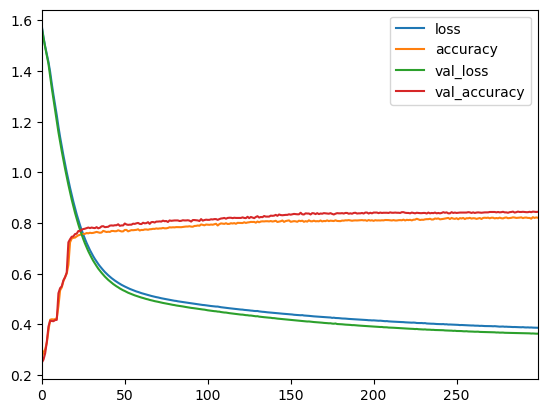

In [7]:
from sklearn.metrics import confusion_matrix

model.compile( loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist = model.fit( X_train, y_train, validation_data=[X_test, y_test], epochs=300, batch_size=200, verbose=0 )

y_pred = model.predict( X_train )

pd.DataFrame( hist.history).plot()

<class 'pandas.core.frame.DataFrame'>


[Text(50.722222222222214, 0.5, 'pred'), Text(0.5, 59.522222222222155, 'obs')]

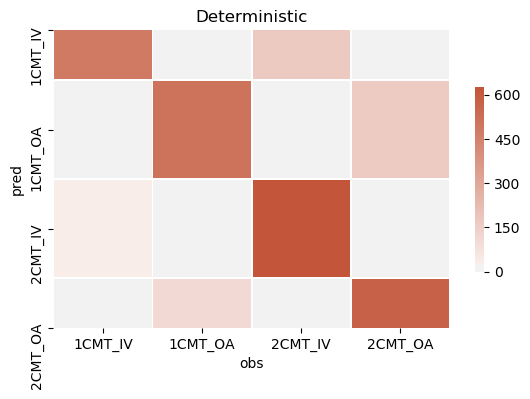

In [8]:
cm = pd.DataFrame( confusion_matrix( y_train.argmax(axis=1), y_pred.argmax(axis=1)),
                  columns=y_enc.classes_, index=y_enc.classes_ )
print( type(cm) )
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
hmap = sns.heatmap( cm, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5} )
hmap.set_title( "Deterministic")
hmap.set(xlabel='obs', ylabel='pred')

In [9]:
_, accuracy = model.evaluate(X_train, y_train, verbose=0)
print( "Accuracy internal:", accuracy)

_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print( "Accuracy external:", accuracy)

Accuracy internal: 0.8216418
Accuracy external: 0.844697


## Stochastic

We now perform the same steps for the stochastic data, i.e. where we have an RUV on the data. Here's what it looks like.

In [10]:
df = pd.read_csv( "../DerivedData/TFPerception_stochastic_train.csv")
df.head

<bound method NDFrame.head of         id  outcome        t0        t1        t2        t4        t6  \
0        5  1CMT_IV  1.000000  0.699745  0.660077  0.626398  0.327165   
1       10  1CMT_IV  0.844857  0.979953  1.000000  0.399162  0.668020   
2       12  1CMT_IV  0.973756  1.000000  0.808742  0.878445  0.610846   
3       15  1CMT_IV  0.485727  0.919062  1.000000  0.617152  0.197262   
4       16  1CMT_IV  1.000000  0.819797  0.530559  0.173769  0.082445   
...    ...      ...       ...       ...       ...       ...       ...   
3995  1994  2CMT_OA  0.000000  0.669656  1.000000  0.840936  0.499777   
3996  1996  2CMT_OA  0.000000  0.471895  0.742717  1.000000  0.517831   
3997  1997  2CMT_OA  0.000000  0.815430  1.000000  0.759310  0.393358   
3998  1998  2CMT_OA  0.000000  1.000000  0.717139  0.437471  0.537510   
3999  1999  2CMT_OA  0.000000  0.829383  1.000000  0.508322  0.291423   

            t8       t12       t24  
0     0.236140  0.114115  0.000000  
1     0.334108  0.4

And here is the model.

Accuracy internal: 0.78656715
Accuracy external: 0.8098485


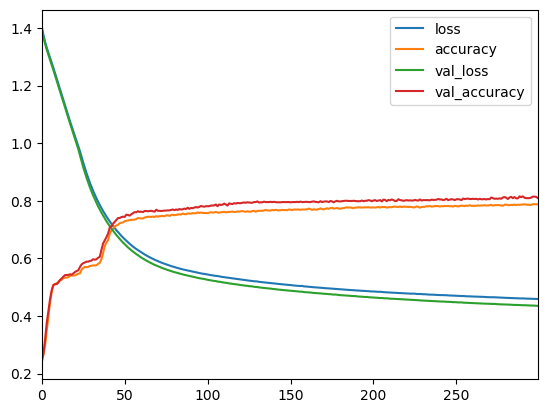

In [11]:
label_encoder = LabelEncoder()
y_enc = label_encoder.fit( df["outcome"] )
# y = label_encoder.fit_transform(df["outcome"])
y = y_enc.transform(df["outcome"].to_numpy())
y = keras.utils.to_categorical(y)

X = df.drop( columns=["id", "outcome"] ).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# use the same model as for deterministic
model = get_perception_model()
model.compile( loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist = model.fit( X_train, y_train, validation_data=[X_test, y_test], epochs=300, batch_size=200, verbose=0 )

y_pred = model.predict( X_train )

pd.DataFrame( hist.history).plot()

_, accuracy = model.evaluate(X_train, y_train, verbose=0)
print( "Accuracy internal:", accuracy)

_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print( "Accuracy external:", accuracy)

Confusion matrix and associated plots

<class 'pandas.core.frame.DataFrame'>


[Text(50.722222222222214, 0.5, 'pred'), Text(0.5, 59.522222222222155, 'obs')]

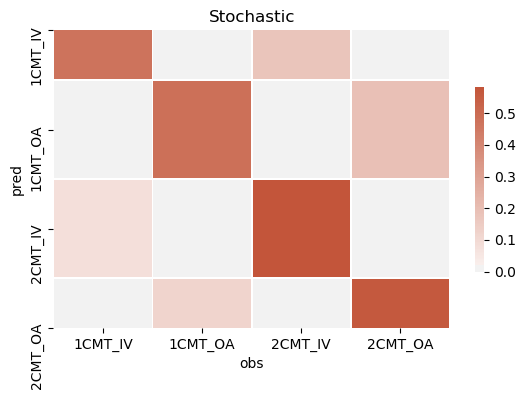

In [12]:
cm = pd.DataFrame( confusion_matrix( y_train.argmax(axis=1), y_pred.argmax(axis=1)),
                  columns=y_enc.classes_, index=y_enc.classes_ ) / 1000
print( type(cm) )
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
hmap = sns.heatmap( cm, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5} )
hmap.set_title( "Stochastic")
hmap.set(xlabel='obs', ylabel='pred')